In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import supervision as sv

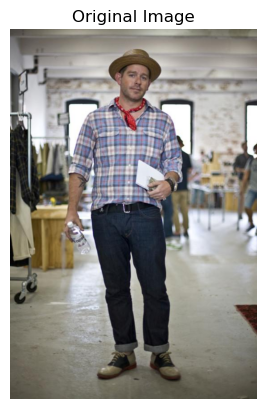

In [37]:
# Set directories
DATA_DIR = "./data/outfits"
PERSON_DIR = "./data/segmented_person"
ITEMS_DIR = "./data/segmented_items"
folders = [DATA_DIR, PERSON_DIR, ITEMS_DIR]

# Create the folders
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Load first image for debugging
image_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise ValueError("No images found in the directory!")
image_path = os.path.join(DATA_DIR, image_files[0])  # Take the first image
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise ValueError(f"Failed to load image: {image_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

# Display original image
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

I0000 00:00:1739297613.903281 3776791 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1739297614.026419 4068611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739297614.054073 4068616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


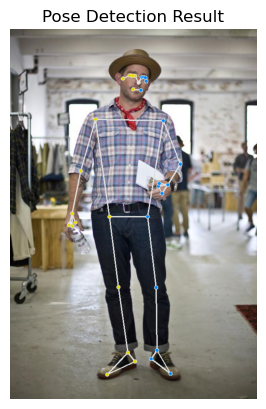

In [38]:
# ---- STEP 1: POSE ESTIMATION ----
# https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/pose_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Pose_Landmarker.ipynb#scrollTo=tzXuqyIBlXer

base_options = python.BaseOptions(model_asset_path='./models/pose_landmarker_full.task')
options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
detection_result = detector.detect(mp_image)
if not detection_result.pose_landmarks:
    raise ValueError("Pose estimation failed!")

# Draw pose landmarks
annotated_image = draw_landmarks_on_image(image_rgb, detection_result)
plt.imshow(annotated_image)
plt.title("Pose Detection Result")
plt.axis("off")
plt.show()

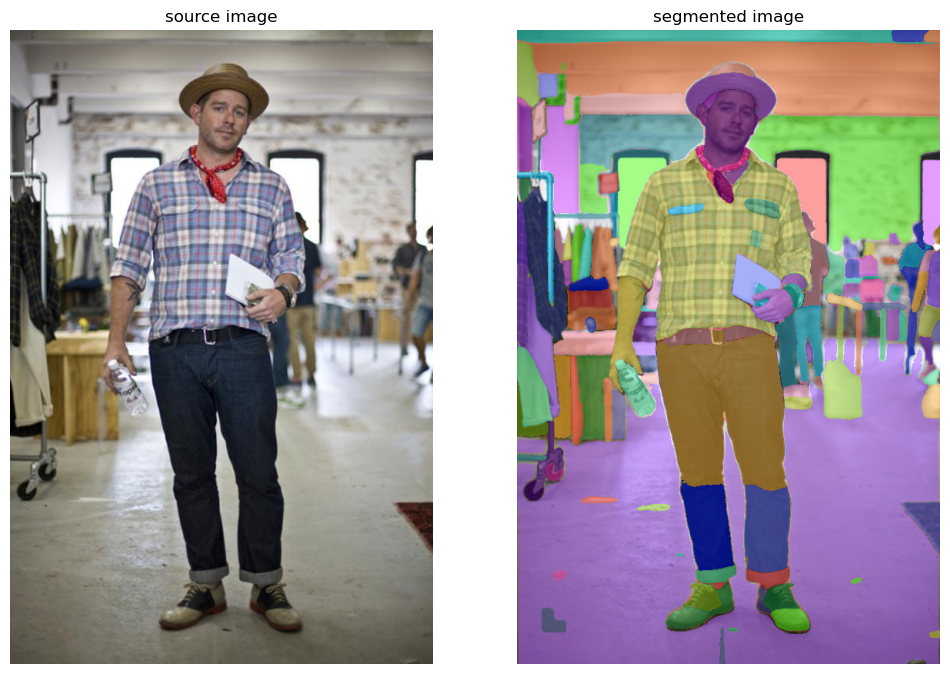

In [39]:
# ---- STEP 2: PERSON SEGMENTATION USING SAM ----
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "./models/sam_vit_h.pth"

# load SAM model with vit_h encoder (636M parameters)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.56,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)
sam_result = mask_generator.generate(image_rgb)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [31]:




predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

# Generate segmentation masks for the person
masks = predictor.predict(box=None, point_coords=None, multimask_output=False)[0]

KeyboardInterrupt: 

In [25]:
# Apply mask to extract the person
binary_mask = masks.astype(np.uint8) * 255
person_segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

# Save segmented person
segmented_person_path = os.path.join(PERSON_DIR, "segmented_person.jpg")
cv2.imwrite(segmented_person_path, cv2.cvtColor(person_segmented, cv2.COLOR_RGB2BGR))

# Display segmented person
plt.imshow(person_segmented)
plt.title("Segmented Person")
plt.axis("off")
plt.show()

error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


In [ ]:
# ---- STEP 3: DEFINE CLOTHING REGIONS AND EXTRACT ITEMS ----
def get_pose_keypoints(pose_landmarks):
    keypoints = {}
    for idx, lm in enumerate(pose_landmarks):
        keypoints[idx] = (int(lm.x * image_rgb.shape[1]), int(lm.y * image_rgb.shape[0]))
    return keypoints

pose_keypoints = get_pose_keypoints(detection_result.pose_landmarks[0])

clothing_regions = {
    "upper_body": [pose_keypoints[11], pose_keypoints[12], pose_keypoints[23], pose_keypoints[24]],
    "lower_body": [pose_keypoints[23], pose_keypoints[24], pose_keypoints[25], pose_keypoints[26]],
    "shoes": [pose_keypoints[27], pose_keypoints[28], pose_keypoints[31], pose_keypoints[32]]
}

for item, keypoints in clothing_regions.items():
    x_min = min([kp[0] for kp in keypoints])
    y_min = min([kp[1] for kp in keypoints])
    x_max = max([kp[0] for kp in keypoints])
    y_max = max([kp[1] for kp in keypoints])

    input_box = np.array([[x_min, y_min, x_max, y_max]])
    masks, _, _ = predictor.predict(box=input_box, multimask_output=False)

    segmented_mask = masks[0].astype(np.uint8) * 255
    segmented_item = cv2.bitwise_and(image_rgb, image_rgb, mask=segmented_mask)

    # Save segmented clothing item
    item_path = os.path.join(ITEMS_DIR, f"{item}.png")
    cv2.imwrite(item_path, cv2.cvtColor(segmented_item, cv2.COLOR_RGB2BGR))

    # Display each clothing segmentation
    plt.imshow(segmented_item)
    plt.title(f"Segmented {item}")
    plt.axis("off")
    plt.show()

In [ ]:
# ---- STEP 4: PERSPECTIVE CORRECTION ----
if all(k in pose_keypoints for k in [11, 12, 23, 24]):
    src_pts = np.array([pose_keypoints[11], pose_keypoints[12], pose_keypoints[23], pose_keypoints[24]], dtype=np.float32)
    dst_pts = np.array([[50, 50], [250, 50], [50, 350], [250, 350]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    outfit_corrected = cv2.warpPerspective(person_segmented, M, (300, 400))

    # Save corrected image
    corrected_path = os.path.join(PERSON_DIR, "corrected_outfit.jpg")
    cv2.imwrite(corrected_path, cv2.cvtColor(outfit_corrected, cv2.COLOR_RGB2BGR))

    # Display corrected image
    plt.imshow(outfit_corrected)
    plt.title("Perspective-Corrected Outfit")
    plt.axis("off")
    plt.show()
else:
    print("Keypoints for perspective correction missing.")

In [16]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the SAM model (make sure you have the correct path to the model checkpoint)
MODEL_TYPE = "vit_h"  # or vit_b, vit_l
CHECKPOINT_PATH = "./models/sam_vit_h.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to("cuda" if torch.cuda.is_available() else "cpu")
mask_generator = SamAutomaticMaskGenerator(sam)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate segmentation masks
masks = mask_generator.generate(image_rgb)

In [17]:
# Function to display the masks
def show_masks(image, masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    for mask in masks:
        segmentation = mask["segmentation"]
        color_mask = np.random.rand(3)  # Random color
        color_mask_expanded = color_mask.reshape((1, 1, 3))
        color_mask_expanded = np.tile(color_mask_expanded, (segmentation.shape[0], segmentation.shape[1], 1))
        
        plt.imshow(segmentation[:, :, np.newaxis] * color_mask_expanded, alpha=0.5)
    
    plt.axis("off")
    plt.show()

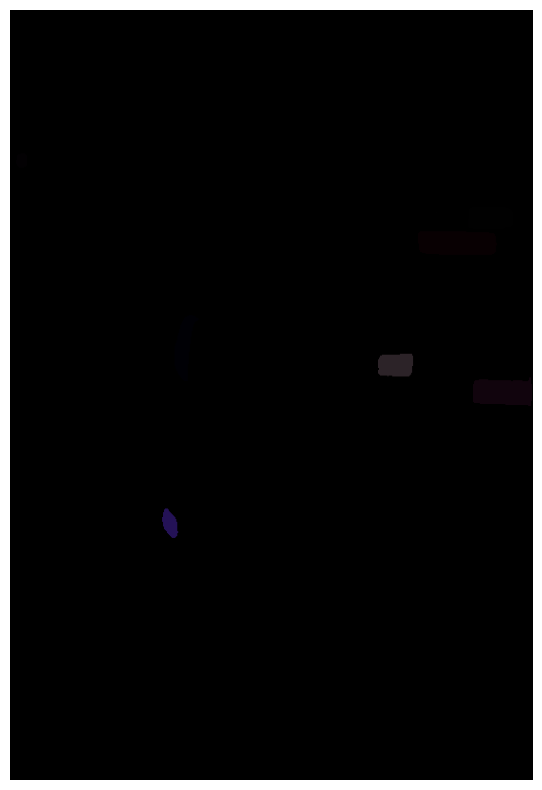

In [18]:
# Display the results
show_masks(image, masks)

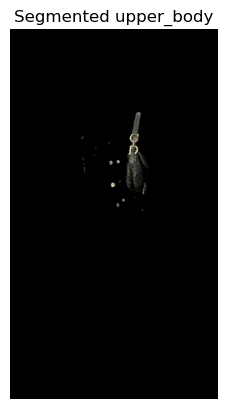

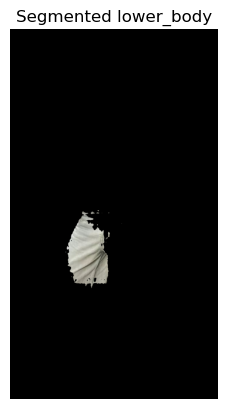

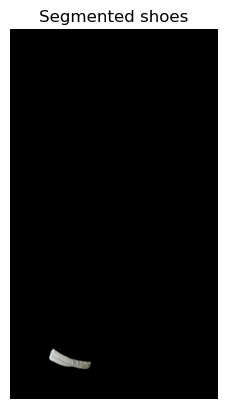

In [46]:
# ---- STEP 2: SEGMENT ANYTHING MODEL (SAM) ----
sam_checkpoint = "./models/sam_vit_h.pth"  # Change to your SAM model path
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

predictor.set_image(image_rgb)

for item, keypoints in clothing_regions.items():
    # Convert keypoints to bounding box [x_min, y_min, x_max, y_max]
    x_min = min([kp[0] for kp in keypoints])
    y_min = min([kp[1] for kp in keypoints])
    x_max = max([kp[0] for kp in keypoints])
    y_max = max([kp[1] for kp in keypoints])

    # Ensure bounding box is within image dimensions
    x_min, y_min = max(0, x_min), max(0, y_min)
    x_max, y_max = min(image.numpy_view().shape[1], x_max), min(image.numpy_view().shape[0], y_max)

    # SAM Segmentation
    input_box = np.array([[x_min, y_min, x_max, y_max]])
    masks, _, _ = predictor.predict(box=input_box, multimask_output=False)

    segmented_mask = masks[0].astype(np.uint8) * 255  # Convert mask to binary
    segmented_item = cv2.bitwise_and(image_rgb, image_rgb, mask=segmented_mask)

    # Save segmented clothing items
    item_path = os.path.join(ITEMS_DIR, f"{item}.png")
    cv2.imwrite(item_path, cv2.cvtColor(segmented_item, cv2.COLOR_RGB2BGR))

    # Display each clothing segmentation
    plt.imshow(segmented_item)
    plt.title(f"Segmented {item}")
    plt.axis("off")
    plt.show()

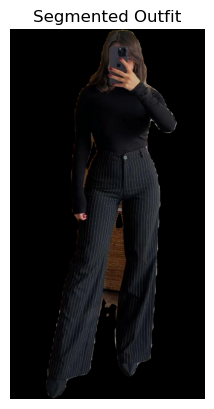

In [33]:
# ---- Step 2: Segmentation ----
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
binary_mask = (segmentation_mask > 0.5).astype(np.uint8)  # Threshold mask

# Apply mask to extract outfit
outfit_segmented = image_rgb * binary_mask[:, :, np.newaxis]

# Save segmented outfit
segmented_path = os.path.join(PERSON_DIR, "segmented_outfit.jpg")
cv2.imwrite(segmented_path, cv2.cvtColor(outfit_segmented, cv2.COLOR_RGB2BGR))

# Display segmented outfit
plt.imshow(outfit_segmented)
plt.title("Segmented Outfit")
plt.axis("off")
plt.show()

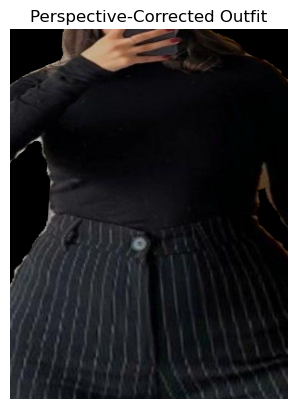

In [36]:
# ---- Step 3: Perspective Correction ----
def get_pose_keypoints(pose_landmarks):
    """Extract key points for perspective correction."""
    keypoints = {}
    for idx, lm in enumerate(pose_landmarks):  # Directly iterate over the list
        keypoints[idx] = (int(lm.x * image_rgb.shape[1]), int(lm.y * image_rgb.shape[0]))
    return keypoints

# Extract keypoints correctly
pose_keypoints = get_pose_keypoints(detection_result.pose_landmarks[0])  # Take first detected person

# Define reference points for transformation (top-left, top-right, bottom-left, bottom-right)
if all(k in pose_keypoints for k in [11, 12, 23, 24]):  # Shoulders & hips
    src_pts = np.array([pose_keypoints[11], pose_keypoints[12], pose_keypoints[23], pose_keypoints[24]], dtype=np.float32)
    dst_pts = np.array([[50, 50], [250, 50], [50, 350], [250, 350]], dtype=np.float32)

    # Compute perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    outfit_corrected = cv2.warpPerspective(outfit_segmented, M, (300, 400))

    # Save corrected image
    corrected_path = os.path.join(PERSON_DIR, "corrected_outfit.jpg")
    cv2.imwrite(corrected_path, cv2.cvtColor(outfit_corrected, cv2.COLOR_RGB2BGR))

    # Display corrected image
    plt.imshow(outfit_corrected)
    plt.title("Perspective-Corrected Outfit")
    plt.axis("off")
    plt.show()

else:
    print("Keypoints for perspective correction missing.")

In [ ]:
# ---- Step 4: Extract Clothing Items ----
def extract_clothing_items(binary_mask, original_image, save_dir):
    """Extracts and saves individual clothing items from the segmented mask."""
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    
    for i in range(1, num_labels):  # Skip background (label 0)
        x, y, w, h, area = stats[i]
        if area < 500:  # Filter small noise
            continue

        item = original_image[y:y+h, x:x+w]
        item_path = os.path.join(save_dir, f"item_{i}.jpg")
        cv2.imwrite(item_path, cv2.cvtColor(item, cv2.COLOR_RGB2BGR))

        plt.imshow(item)
        plt.title(f"Item {i}")
        plt.axis("off")
        plt.show()

extract_clothing_items(binary_mask, outfit_segmented, ITEMS_DIR)

In [ ]:
# WeirdOutfitStyle
from datasets import load_dataset
ds = load_dataset("Norod78/WeirdOutfitStyle")

In [ ]:
# Office Outfit Train Data
import kagglehub
path = kagglehub.dataset_download("jubeena/office-outfit-train-outfits")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("llkdev/fashionstyle")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("khizerraza/men-vs-women-images-dataset")
print("Path to dataset files:", path)